## Set up

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20'

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.manifold import TSNE

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
assert tf.__version__ >= '2.0'

from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Input, Dropout, MaxPooling2D, Flatten, MaxPool2D, MaxPool3D, UpSampling2D
from tensorflow.keras.layers import Conv2DTranspose, Flatten, Reshape, Cropping2D, Embedding
from tensorflow.keras.layers import LeakyReLU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Common imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import dask
import math
dask.config.set({'array.slicing.split_large_chunks': False})

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import cartopy.crs as ccrs
import matplotlib as mpl
from matplotlib import animation
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

from IPython.display import HTML
from IPython.display import Audio
import IPython


mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Custom utils
from utils_data import *
from utils_ml import *
from utils_M3 import *
from utils_cluster import *


Num GPUs Available:  0


<frozen importlib._bootstrap>:219: UserWarning: PROJ 8+ is required. Current version: 7.2.0


In [2]:
tf.version.VERSION

'2.7.0'

In [3]:
era_dir = '/Users/noeliaotero/Documents/OCCR/data/ERA5/geopotential/'
G = 9.80665 
# Some constants
DATE_START = '1979-01-01'
DATE_END = '2020-12-31'
YY_TRAIN = [1979, 2015]
YY_TEST = [2016, 2020]
gp_dat = xr.open_mfdataset(f'{era_dir}Day/*.nc', combine='by_coords', parallel = True)
l500=3

In [4]:
z500 = gp_dat.sel(time=slice(DATE_START, DATE_END))
# rename dimensions
z500= rename_dimensions_variables(z500)
z500.z.values= z500.z.values/G
lon = z500.lon
lat = z500.lat
mvar = 'z'

In [5]:
# Grid options (total extent: 80° lon & 50° lat)
resolution = 1
nb_lat = 20 * 1/resolution + 1
nb_lon = 30 * 1/resolution + 1

In [6]:
# Load gridded data
# ds_z = extract_points_around_CH(z500, step_lat=resolution, step_lon=resolution, nb_lat=nb_lat, nb_lon=nb_lon, levels=[300, 500, 700, 850, 1000])
ds_z = z500
d_copy = z500

In [7]:
# Define coordinates
lats = ds_z.lat
lons = ds_z.lon

In [8]:
ds_z = ds_z.drop_dims('bnds')
d_copy = d_copy.drop_dims('bnds')

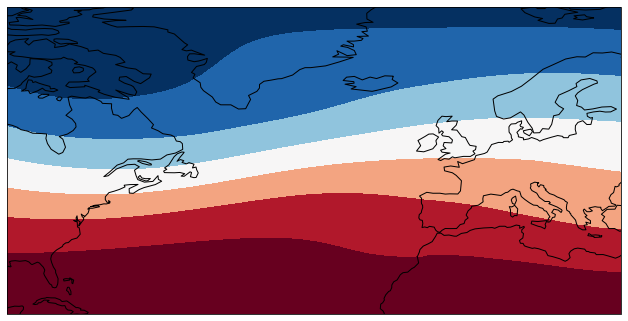

In [9]:
# Visualize
ds_mean = ds_z.mean(dim='time')
ds_mean.z.shape
#fig, axs = plt.subplots(2, 2)
#axs=axs.flatten()
# clevs=np.arange(-160,160,20)
fig, axs = plt.subplots(nrows=1,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(11,8.5))
cs=axs.contourf(lon,lat,ds_mean['z'],cmap=plt.cm.RdBu_r,
                          transform = ccrs.PlateCarree(),extend='both')
axs.coastlines()
    
#fig.subplots_adjust(bottom=0.2, top=0.9, left=0.1, right=0.9,
#                    wspace=0.02, hspace=0.02)
# Add a colorbar axis at the bottom of the graph


In [10]:
# K-Means
# Apply Kmeans previously, so this can help us to make some interpretation of the latent space
# the clusters might be interpreted as the "labels"?? still working on it...

In [11]:
N=8
K_labels = KCluster_v2(ds_z, 'z', 8) # let's start with 8 clusters
day_clus, myclusters, nfreq = getclus_v2(K_labels, ds_z, 8)

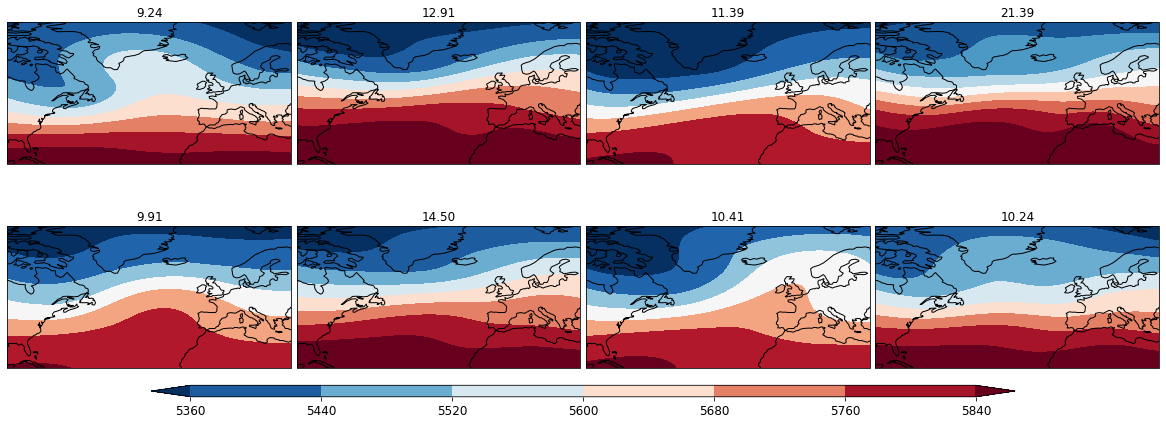

In [12]:
#Visualise the clusters
visCluster(myclusters, nfreq, 8)

In [13]:
# Get the "labels" e.g. clusters
y_labels = getclus_cat(K_labels, d_copy)

In [14]:
y_labels.shape

(15341, 61, 121)

In [15]:
# Split set into (training + validation) and testing based on dates
z_train_full = ds_z.sel(time=slice('{}-01-01'.format(YY_TRAIN[0]), '{}-12-31'.format(YY_TRAIN[1])))
z_test = ds_z.sel(time=slice('{}-01-01'.format(YY_TEST[0]), '{}-12-31'.format(YY_TEST[1])))


In [16]:
# For the data generator all variables have to be merged into a single dataset.
datasets = [ds_z]
ds = xr.merge(datasets)
ds.expand_dims('level', axis=1)

<xarray.Dataset>
Dimensions:  (time: 15341, lon: 121, lat: 61, level: 1)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T11:00:00 ... 2020-12-31T11:00:00
  * lon      (lon) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 27.0 28.0 29.0 30.0
  * lat      (lat) float32 80.0 79.0 78.0 77.0 76.0 ... 24.0 23.0 22.0 21.0 20.0
Dimensions without coordinates: level
Data variables:
    z        (time, level, lat, lon) float32 5.231e+03 5.224e+03 ... 5.849e+03
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Wed Nov 03 19:48:27 2021: cdo daymean /Users/noeliaotero/Do...
    frequency:    day
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

In [17]:
# Split into training and test, then I will use DataGenerator class to get the validation

# I am going to use only Z500 for now:
ds_train = ds.sel(time=slice('{}-01-01'.format(YY_TRAIN[0]), '{}-12-31'.format(YY_TRAIN[1])))
ds_test = ds.sel(time=slice('{}-01-01'.format(YY_TEST[0]), '{}-12-31'.format(YY_TEST[1])))

In [18]:
# Clear session and set tf seed
keras.backend.clear_session()
tf.random.set_seed(42)

In [19]:

class DataGenerator(keras.utils.Sequence):
    def __init__(self, ds, var_dict, batch_size=32, shuffle=True, load=True, mean=None, std=None):
    #def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True, mean=None, std=None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours # I am skipping it for now
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """
        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        #self.lead_time = lead_time

        data = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for var, levels in var_dict.items():
            #try:
            #    data.append(ds[var].sel(level=levels))
            #except ValueError:
                data.append(ds[var].expand_dims({'level': generic_level}, 1))

        # I removed self.data.mean(('time', 'lat', 'lon')).compute()
        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.mean = self.data.mean(('time', 'lat', 'lon')) if mean is None else mean
        self.std = self.data.std('time').mean(('lat', 'lon')) if std is None else std
        # Normalize
        self.data = (self.data - self.mean) / self.std
        #self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        #self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        #self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        #self.on_epoch_end()
        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.data.load()

In [20]:
from collections import OrderedDict
# then we need a dictionary for all the variables and levels we want to extract from the dataset
# dic = OrderedDict({'z': None, 'T2MMEAN': None})
dic = OrderedDict({'z': None})
bs = 32

In [21]:
# Create a training and test data generator. Use the train mean and std for validation as well.
dg_train = DataGenerator(
    ds_train.sel(time=slice('1979', '2015')), dic, batch_size=bs, load=True)


Loading data into RAM


In [22]:
dg_train.mean, dg_train.std

(<xarray.DataArray 'z' (level: 1)>
 array([5555.0845], dtype=float32)
 Coordinates:
   * level    (level) int64 1,
 <xarray.DataArray 'z' (level: 1)>
 array([149.08905], dtype=float32)
 Coordinates:
   * level    (level) int64 1)

In [23]:
# Now also a generator for testing. Impartant: Shuffle must be False!
dg_test = DataGenerator(ds_test, dic, batch_size=bs, mean=dg_train.mean, std=dg_train.std, shuffle=False)


Loading data into RAM


In [24]:
# I will select the 12 first modes or components (like for the PCA)
n_codings = 12

In [25]:
# define a simple autoencoder:
# The AE contains: encoder, which compresses the images into a 64 dimensional latent vector, 
# and a decoder, that reconstructs the original image from the latent space.

latent_dim = n_codings 

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim   
        self.encoder = tf.keras.Sequential([
          layers.Flatten(),
          layers.Dense(latent_dim, activation='linear'),
          layers.BatchNormalization(),
          layers.ReLU(),
        ])
        # Check the dimensions!!!!!!!!!
        self.decoder = tf.keras.Sequential([
          layers.Dense(61*121, activation='linear'),   
          layers.Reshape((61, 121)),
          layers.BatchNormalization(),   # adding batchNormalization doesn't seem to improve this
          layers.ReLU(),
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(latent_dim)

In [26]:
autoencoder.compile(optimizer='adam', loss='mse')

In [27]:
shape = ds_train.z.shape
shape

(13514, 61, 121)

In [28]:
# Prepare the data
X_train = xr.DataArray(ds_train.z)
X_test = xr.DataArray(ds_test.z)

In [29]:
# Just if I wanted 2D
X_train_stack = X_train.stack(point=["lat", "lon"])
X_test_stack = X_test.stack(point=["lat", "lon"])

In [30]:
X_train_input = np.array(X_train)
X_test_input = np.array(X_test)

In [31]:
print(X_train_input.shape)
print(X_test_input.shape)

(13514, 61, 121)
(1827, 61, 121)


In [32]:
hist1 = autoencoder.fit(X_train_input, X_train_input,
                epochs=10,
                shuffle=True,
                validation_data=(X_test_input, X_test_input))

Epoch 1/10
423/423 [==============================] - 3s 5ms/step - loss: 30922778.0000 - val_loss: 31037080.0000
Epoch 2/10
423/423 [==============================] - 2s 5ms/step - loss: 30917220.0000 - val_loss: 31042810.0000
Epoch 3/10
423/423 [==============================] - 2s 5ms/step - loss: 30911368.0000 - val_loss: 31029532.0000
Epoch 4/10
423/423 [==============================] - 2s 5ms/step - loss: 30905672.0000 - val_loss: 31039600.0000
Epoch 5/10
423/423 [==============================] - 2s 5ms/step - loss: 30900204.0000 - val_loss: 31050088.0000
Epoch 6/10
423/423 [==============================] - 2s 5ms/step - loss: 30894736.0000 - val_loss: 31047828.0000
Epoch 7/10
423/423 [==============================] - 2s 4ms/step - loss: 30889350.0000 - val_loss: 31041850.0000
Epoch 8/10
423/423 [==============================] - 2s 5ms/step - loss: 30883968.0000 - val_loss: 31035436.0000
Epoch 9/10
423/423 [==============================] - 2s 4ms/step - loss: 30878590.0000 

In [43]:
encoded_imgs = autoencoder.encoder(X_test_input).numpy()

In [44]:
encoded_imgs.shape

(1827, 12)

In [45]:
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [46]:
decoded_imgs.shape

(1827, 61, 121)

In [47]:
reconstructions_ae1 = autoencoder.predict(X_test_input)

In [48]:
reconstructions_ae1.shape

(1827, 61, 121)

In [49]:
encoded_imgs = autoencoder.encoder.predict(X_test_input)

In [50]:
encoded_imgs.shape

(1827, 12)

In [51]:
decoded_imgs = autoencoder.decoder.predict(encoded_imgs)

In [52]:
decoded_imgs.shape

(1827, 61, 121)

In [53]:
# Latent space representaion

In [54]:
# using the clusters
#clus_orig = np.stack(y_labels.z)
#latent_clus_space = autoencoder.encoder(clus_orig)

In [55]:
# Repeat the process building up the ae 

In [67]:
#Define the input layer of the neural network, which will be our  dataset
n_size = X_train_input.shape[1:] 
n_code = n_codings
activation_function = 'linear'
optimizer = 'adam'
n_flatsize = np.product(n_size)
print(n_size, n_code, n_flatsize)
bottleneck_size = 2 

(61, 121) 12 7381


In [68]:
# Another way to define the AE
# Defines encoder

stacked_encoder = keras.models.Sequential(
    [
    keras.layers.Flatten(input_shape=n_size),
    keras.layers.Dense(128, activation=activation_function),
    keras.layers.Dense(bottleneck_size, activation=activation_function),
    ])

In [69]:
stacked_encoder.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 7381)              0         
                                                                 
 dense_15 (Dense)            (None, 128)               944896    
                                                                 
 dense_16 (Dense)            (None, 2)                 258       
                                                                 
Total params: 945,154
Trainable params: 945,154
Non-trainable params: 0
_________________________________________________________________


In [70]:
# Define decoder
stacked_decoder = keras.models.Sequential(
    [
    keras.layers.Dense(128, activation=activation_function, input_shape=[bottleneck_size]),
    keras.layers.Dense(n_flatsize),
    keras.layers.Reshape(n_size)
    ])

In [71]:
stacked_decoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 128)               384       
                                                                 
 dense_18 (Dense)            (None, 7381)              952149    
                                                                 
 reshape_2 (Reshape)         (None, 61, 121)           0         
                                                                 
Total params: 952,533
Trainable params: 952,533
Non-trainable params: 0
_________________________________________________________________


In [72]:
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])

In [73]:
stacked_ae.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 2)                 945154    
                                                                 
 sequential_7 (Sequential)   (None, 61, 121)           952533    
                                                                 
Total params: 1,897,687
Trainable params: 1,897,687
Non-trainable params: 0
_________________________________________________________________


In [74]:
stacked_ae.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mae','mse'])


In [75]:
history = stacked_ae.fit(X_train_input, X_train_input, epochs=10, validation_data=(X_test_input, X_test_input),shuffle=True)

Epoch 1/10
423/423 [==============================] - 4s 9ms/step - loss: 2599782.0000 - mae: 477.6606 - mse: 2599784.0000 - val_loss: 15497.0498 - val_mae: 98.5075 - val_mse: 15497.0488
Epoch 2/10
423/423 [==============================] - 4s 9ms/step - loss: 38093.8008 - mae: 122.9000 - mse: 38093.7734 - val_loss: 13668.3828 - val_mae: 92.1794 - val_mse: 13668.3828
Epoch 3/10
423/423 [==============================] - 4s 9ms/step - loss: 19110.9336 - mae: 104.5469 - mse: 19110.9258 - val_loss: 14898.6729 - val_mae: 96.3216 - val_mse: 14898.6758
Epoch 4/10
423/423 [==============================] - 4s 9ms/step - loss: 19912.2070 - mae: 108.6996 - mse: 19912.2031 - val_loss: 14211.9551 - val_mae: 94.5123 - val_mse: 14211.9531
Epoch 5/10
423/423 [==============================] - 4s 9ms/step - loss: 25135.9512 - mae: 113.9273 - mse: 25135.9395 - val_loss: 16142.2012 - val_mae: 100.3247 - val_mse: 16142.2031
Epoch 6/10
423/423 [==============================] - 4s 10ms/step - loss: 24122

In [83]:
encoded_imgs = stacked_encoder.predict(X_test_input)

In [84]:
encoded_imgs.shape

(1827, 2)

In [87]:
decoded_imgs = stacked_decoder.predict(encoded_imgs)
decoded_imgs.shape

(1827, 61, 121)

In [174]:
def onclick(event):
    global flag
    ix, iy = event.xdata, event.ydata
    latent_vector = np.array([[ix, iy]])
    
    decoded_img = stacked_decoder.predict(latent_vector)
    # Create a new data set to add the decoded
    # to plot
    dat_toplot = xr.DataArray(decoded_img[0,:,:])
    #test.plot(cmap=plt.cm.RdBu_r)
    #ds_newtest['decoded'] = (('lat','lon'), decoded_imgs[0,:,:])
    
    dat_toplot.plot(ax=ax[1],cmap=plt.cm.RdBu_r,add_colorbar=False)
    plt.draw()
    #fig.canvas.draw()
    

<IPython.core.display.Javascript object>


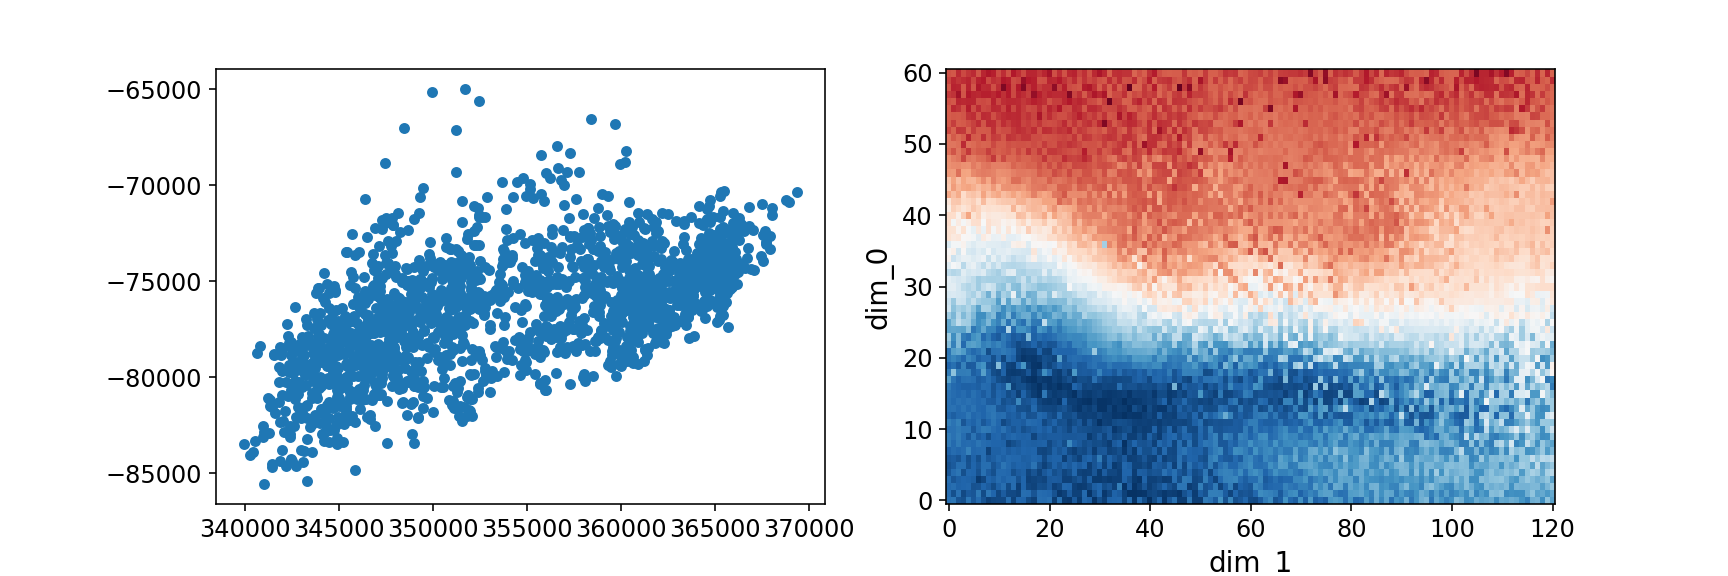

In [175]:
%matplotlib notebook
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].scatter(encoded_imgs[:,0],encoded_imgs[:,1], s=20, cmap='tab10')
cid = fig.canvas.mpl_connect('motion_notify_event', onclick)

plt.show()

In [176]:
last_mse = history.history['val_mse'][-1]
last_mae = history.history['val_mae'][-1]
print(last_mse, last_mae)

86813.90625 269.3885192871094


In [177]:
codings = stacked_encoder.predict(X_test_input)
codings.shape # this are similar as the PCA (the first that we kept)

(1827, 2)

In [178]:
reconstructions = stacked_ae.predict(X_test_input)

In [179]:
reconstructions.shape

(1827, 61, 121)

In [187]:
ds_newtest = ds_test.z
ds_newtest['X_valid'] = (('time','lat','lon'), X_test_input)

In [188]:
ds_newtest['X_recons_AE'] = (('time','lat','lon'), reconstructions)

In [189]:
#ds_newtest['X_recons_AE1'] = (('time','lat','lon'), reconstructions_ae1)

<IPython.core.display.Javascript object>


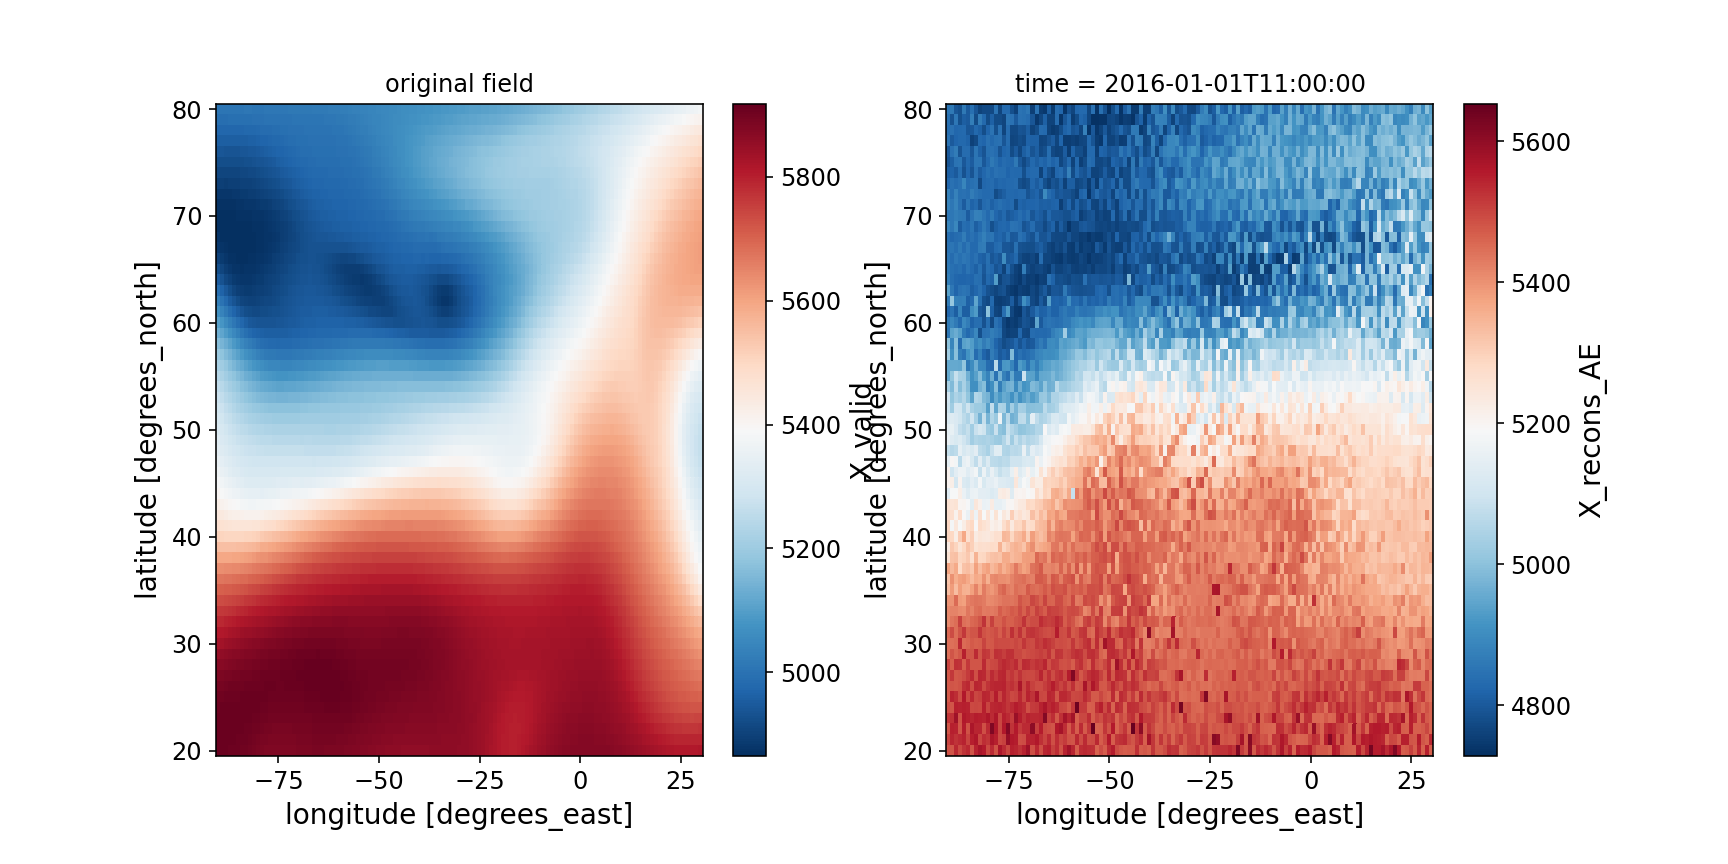

Text(0.5, 1.0, 'original field')

In [190]:
# let's plot
i=0
f, axes = plt.subplots(ncols=2, figsize=(12, 6))

ds_newtest.isel(time=i)['X_valid'].plot(ax=axes[0], cmap=plt.cm.RdBu_r)

ds_newtest.isel(time=i)['X_recons_AE'].plot(ax=axes[1],cmap=plt.cm.RdBu_r)

axes[0].set_title('original field')

In [191]:
lp = ['X_valid','X_recons_AE']


In [192]:
type(ds_newtest['X_valid'])

xarray.core.dataarray.DataArray

<IPython.core.display.Javascript object>


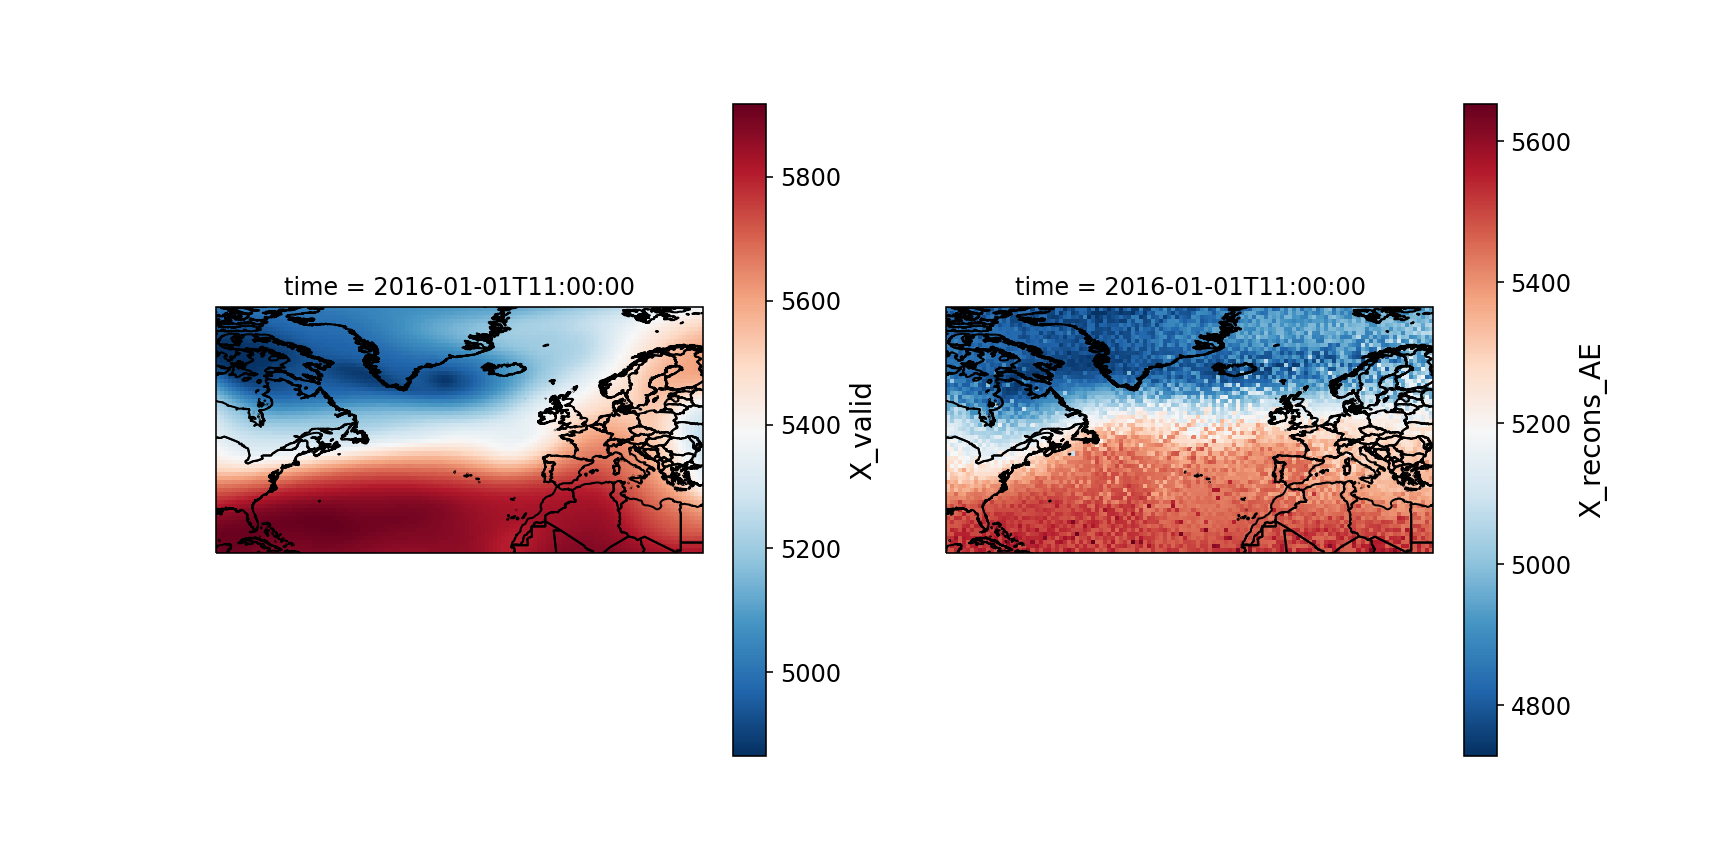

In [193]:

# This is the map projection we want to plot *onto*
from cartopy.feature import NaturalEarthFeature
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(12,6))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

for i, ax in enumerate(axes.flatten()):
    #print(i)
    #print(lp[i])
    ds_newtest.isel(time=0)[lp[i]].plot(ax=axs[i], transform=ccrs.PlateCarree(),cmap=plt.cm.RdBu_r)
    axs[i].add_feature(NaturalEarthFeature('cultural', 'admin_0_countries', '10m'),
                      facecolor='none', edgecolor='black')


## Convolutional AutoEncoder 


In [174]:
from tensorflow.keras import datasets, layers, models, losses, Model
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Conv2DTranspose


In [175]:
# Encoder
N, H, W = X_train_input.shape
input_img = Input(shape=(H,W,1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


In [176]:
# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded  = Conv2D(1, (2, 2), activation='relu')(x)
decoded_cropping = Cropping2D(cropping=((2, 0), (6, 0)))(decoded) # I added this crop to match shapes!!!!! (but I have not idea! o_o)

In [177]:
cae_autoencoder = Model(input_img, decoded_cropping)
cae_autoencoder.compile(optimizer='adam', loss='mse')

cae_autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 61, 121, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 61, 121, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 61, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 61, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 31, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 31, 8)         584   

In [185]:
hist_cae = cae_autoencoder.fit(X_train_input, X_train_input, epochs=10,validation_data=(X_test_input, X_test_input))

Epoch 1/10
423/423 [==============================] - 54s 128ms/step - loss: 1869.8635 - val_loss: 955.4343
Epoch 2/10
423/423 [==============================] - 52s 124ms/step - loss: 1870.4255 - val_loss: 931.8383
Epoch 3/10
423/423 [==============================] - 54s 128ms/step - loss: 1743.7396 - val_loss: 4554.9243
Epoch 4/10
423/423 [==============================] - 56s 132ms/step - loss: 1809.9304 - val_loss: 947.0262
Epoch 5/10
423/423 [==============================] - 54s 127ms/step - loss: 1604.5262 - val_loss: 1361.4872
Epoch 6/10
423/423 [==============================] - 58s 137ms/step - loss: 1720.5225 - val_loss: 1027.5930
Epoch 7/10
423/423 [==============================] - 55s 130ms/step - loss: 1587.7678 - val_loss: 974.0980
Epoch 8/10
423/423 [==============================] - 54s 128ms/step - loss: 1581.9479 - val_loss: 740.9056
Epoch 9/10
423/423 [==============================] - 51s 122ms/step - loss: 1545.4550 - val_loss: 767.9606
Epoch 10/10
423/423 [====

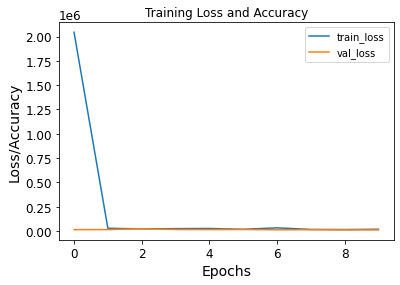

In [187]:
plot_hist(hist_cae)

In [189]:
reconstructions_cae = cae_autoencoder.predict(X_test_input)
reconstructions_cae.shape

(1827, 61, 121, 1)

In [190]:
reconstructions_cae2 = reconstructions_cae[:, :, :, 0]
reconstructions_cae2.shape

(1827, 61, 121)

In [191]:
# add to the existing data to compare with
ds_newtest['X_recons_CAE'] = (('time','lat','lon'), reconstructions_cae2)

Text(0.5, 1.0, 'original field')

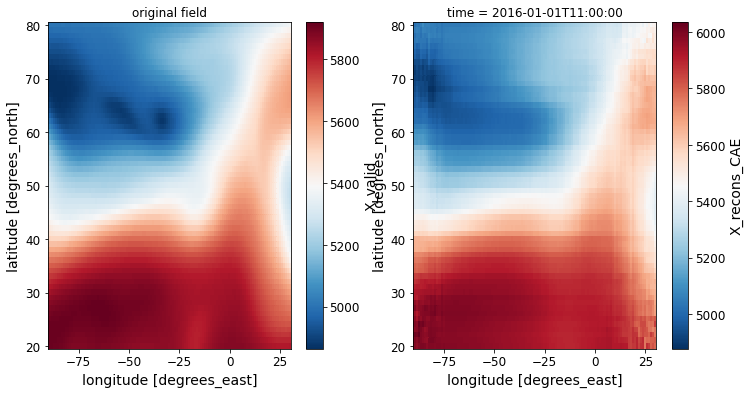

In [192]:
i=0
f, axes = plt.subplots(ncols=2, figsize=(12, 6))

ds_newtest.isel(time=i)['X_valid'].plot(ax=axes[0], cmap=plt.cm.RdBu_r)

ds_newtest.isel(time=i)['X_recons_CAE'].plot(ax=axes[1],cmap=plt.cm.RdBu_r)

axes[0].set_title('original field')

## Comparing with PCA 

In [193]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import RFE
skpca = PCA()
skpca.fit(X_train_input.reshape(X_train_input.shape[0],X_train_input.shape[1] * X_train.shape[2]))
PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)
X_train_input.shape


(13514, 61, 121)

In [194]:
PCs = skpca.transform(X_test_input.reshape(X_test_input.shape[0],X_test_input.shape[1] * X_test_input.shape[2]))
PCs.shape

PCs = PCs[:,:n_codings]
EOFs = skpca.components_
EOFs = EOFs[:n_codings,:]
print(EOFs.shape)
print(PCs.shape)


(12, 7381)
(1827, 12)


In [195]:
recons_pca = np.dot(PCs, EOFs)
recons_pca.shape
recons_pca = recons_pca.reshape(recons_pca.shape[0],  X_train_input.shape[1], X_train_input.shape[2])
recons_pca.shape

(1827, 61, 121)

Text(0.5, 1.0, 'original field')

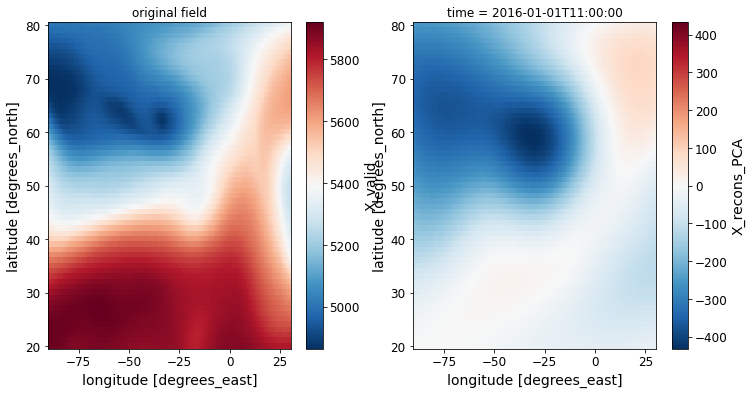

In [196]:
ds_newtest['X_recons_PCA'] = (('time','lat','lon'), recons_pca)
i = 0
f, axes = plt.subplots(ncols=2, figsize=(12, 6))

ds_newtest.isel(time=i)['X_valid'].plot(ax=axes[0], cmap=plt.cm.RdBu_r)

ds_newtest.isel(time=i)['X_recons_PCA'].plot(ax=axes[1], cmap=plt.cm.RdBu_r)

axes[0].set_title('original field')